# 🎤 NB03: Data Visualisation

In [1]:
# Importing necessary libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from lets_plot import *
LetsPlot.setup_html()
from os import path
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from IPython.display import Image, display
from PIL import Image as PILImage
import numpy as np
from scipy.interpolate import splprep, splev
from dotenv import load_dotenv
from functions import *
from auth import *
from pprint import pprint
from bs4 import BeautifulSoup

In [16]:
LetsPlot.setup_html()

artists_df = pd.read_csv("../data/processed/top_50_artists.csv")

# Assuming your DataFrame is called 'artists_df' with columns 'Artist' and 'Count'
top_50_artists = artists_df.nlargest(35, 'count')

# Create a sorted DataFrame for better readability
sorted_artists = top_50_artists.sort_values('count', ascending=True)

# Plot using Lets-Plot
p = ggplot(sorted_artists, aes(x='count', y='Artists')) + \
    geom_bar(stat='identity', fill='pink', width=0.8) + \
    coord_flip() + \
    ggsize(800, 600) + \
    ggtitle('Figure 1. Top 35 Artists by Count') + \
    xlab('Number of Songs in Combined Playlist') + \
    ylab('Artists') + \
    theme(axis_text_y=element_text(size=10))

p.show()

I wanted to visualize the top pop artists, ranked by how many times their songs feature on the combined playlist. Looking at the data, I decided on 5 female and 5 male artists. 

One interesting thing about this data is a male artist does not rank until no. 19 on the list (Bruno Mars). This might be an interesting area to explore in future research: whether female artists create more pop hits, compared to male artists.

In [3]:
# Path to your SQLite database
db_path = '../data/spotify.db'

# Connect to the database
conn = sqlite3.connect(db_path)

# Query for male artists (gender = 0)
male_artists_df = pd.read_sql_query(
    "SELECT * FROM top_tracks WHERE gender = 0;", conn
)

# Query for female artists (gender = 1)
female_artists_df = pd.read_sql_query(
    "SELECT * FROM top_tracks WHERE gender = 1;", conn
)

In [4]:
# Fetch lyrics for male artists
male_artists_query = "SELECT Lyrics FROM top_tracks WHERE Gender = 0;"
male_lyrics = conn.execute(male_artists_query).fetchall()
male_lyrics_text = " ".join([row[0] for row in male_lyrics if row[0]])  # Combine all lyrics into one string

# Fetch lyrics for female artists
female_artists_query = "SELECT Lyrics FROM top_tracks WHERE Gender = 1;"
female_lyrics = conn.execute(female_artists_query).fetchall()
female_lyrics_text = " ".join([row[0] for row in female_lyrics if row[0]])  # Combine all lyrics into one string

# Get word frequencies
male_word_freq = get_most_frequent_words(male_lyrics_text)
female_word_freq = get_most_frequent_words(female_lyrics_text)

# Sort frequencies in descending order
male_word_freq = sorted(male_word_freq.items(), key=lambda x: x[1], reverse=True)
female_word_freq = sorted(female_word_freq.items(), key=lambda x: x[1], reverse=True)

In [5]:
# Fetch lyrics for male and female artists
male_artists_query = "SELECT Lyrics FROM top_tracks WHERE Gender = 0;"
female_artists_query = "SELECT Lyrics FROM top_tracks WHERE Gender = 1;"

# Execute queries and fetch results
male_lyrics = conn.execute(male_artists_query).fetchall()
female_lyrics = conn.execute(female_artists_query).fetchall()

# Extract lyrics as lists of strings
male_lyrics_list = [row[0] for row in male_lyrics if row[0]]  # Avoid None or empty strings
female_lyrics_list = [row[0] for row in female_lyrics if row[0]]

# Get the most frequent words for male and female artists
male_word_freq = get_most_frequent_words_final(male_lyrics_list)
female_word_freq = get_most_frequent_words_final(female_lyrics_list)

# Sort the word frequencies in descending order
male_word_freq = sorted(male_word_freq.items(), key=lambda x: x[1], reverse=True)
female_word_freq = sorted(female_word_freq.items(), key=lambda x: x[1], reverse=True)

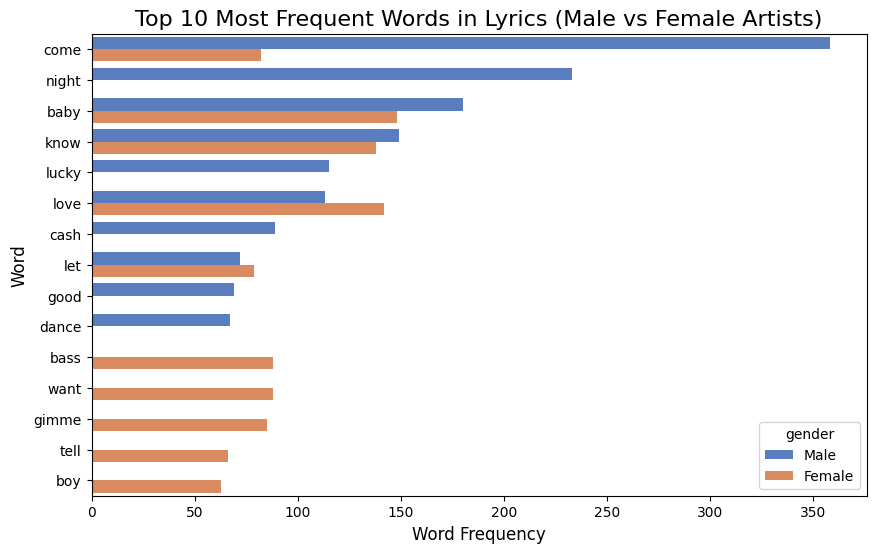

In [6]:
# Bar plotting most frequent words using Matplotlib
plot_word_frequencies(male_word_freq, female_word_freq, top_n=10)

The above plot shows the words most frequently used in male and female musical artists' song lyrics. As it visualizes, some of the most frequent words for male lyrics are "come", "night", and "baby"; while the most frequent words for female lyrics are "baby", "love", and "know". 

This is especially interesting, because "night" is only featured frequently in male lyrics (alongside "lucky"), while the other frequent words are present in both genders.

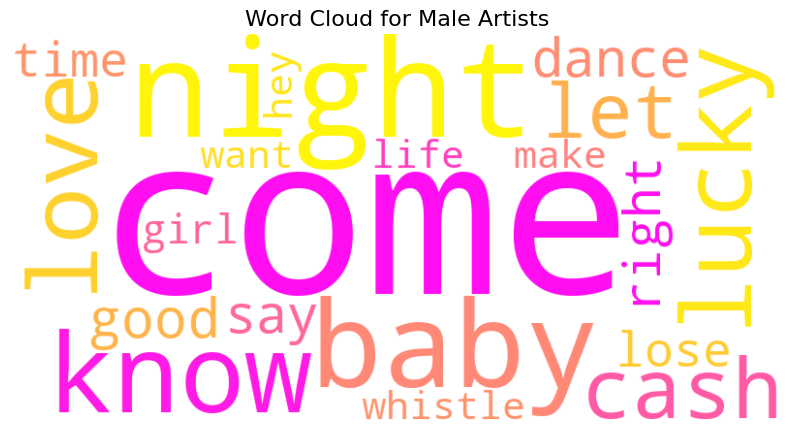

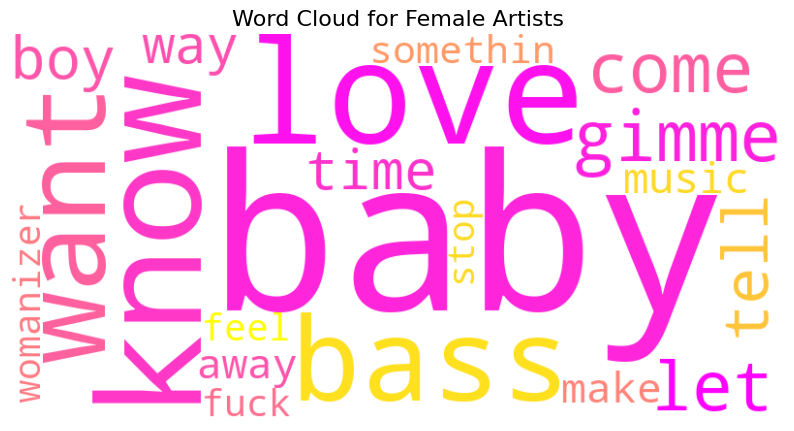

In [ ]:
# Plotting the word clouds for male and female artists
plot_word_cloud(male_word_freq, title="Figure 3. Word Cloud for Male Artists", save_path="../images/male_wordcloud1.png")
plot_word_cloud(female_word_freq, title="Figure 4. Word Cloud for Female Artists", save_path="../images/female_wordcloud1.png")

The above word clouds highlight a conclusion reached by my references: that female singer-songwriters focus more on (romantic) love in their lyrics, while [male singer-songwriters are more likely to focus on sexual themes](https://journals.sagepub.com/doi/10.1177/0305735619871602). Figures 3 and 4 seem to prove this, as the largest (most frequent words) in male lyrics are "night", "lucky", "come"; while they are "baby", "love", "know" in female lyrics (although there are still sexual themes present in the majority of female lyrics too, such as "womanizer", "f**k", "gimme")

In [8]:
query = "SELECT Lyrics, gender FROM top_tracks WHERE Lyrics IS NOT NULL"
df = pd.read_sql_query(query, conn)

I wanted to make it a bit more visually interesting, so I plotted the word clouds in the shape of singer masks (Justin Bieber and Nicki Minaj, both top artists for their genders) and colour-picked from the images.

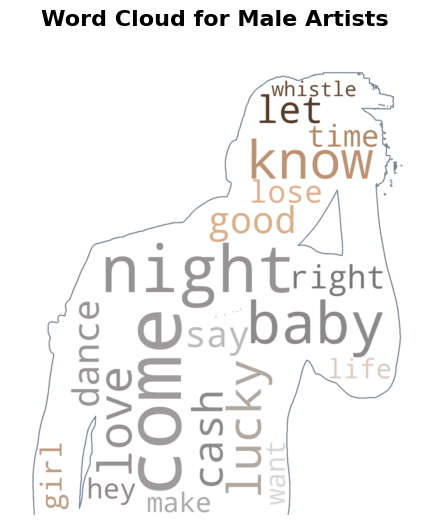

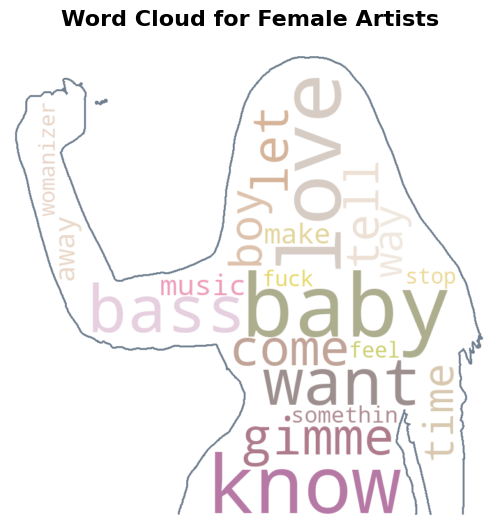

In [ ]:
# Calling silhouette masks to fit the word clouds into
male_mask_path = "../images/justin.png" 
female_mask_path = "../images/nicki.png"  

# Using the plot_shaped_word_cloud function to plot male and female word clouds, based on singer silhouette masks
# Colours are also picked from the original images
plot_shaped_word_cloud(male_word_freq, mask_path=male_mask_path, title="Figure 5. Word Cloud for Male Artists", max_words=2000)
plot_shaped_word_cloud(female_word_freq, mask_path=female_mask_path, title="Figure 6. Word Cloud for Female Artists", max_words=2000)

In [ ]:
# Creating a cursor object to execute SQL queries
cursor = conn.cursor()

# SQL query to create the merged table, with the foreign key "Artists"
create_merged_table_query = """
CREATE TABLE IF NOT EXISTS merged_table AS
SELECT 
    p."Track Name" AS playlist_track_name,
    p."Track ID",
    p."Artists",
    p."Artist Count",
    t."Track Name" AS top_track_name,
    t."Gender",
    t."Lyrics"
FROM 
    playlists p
LEFT JOIN 
    top_tracks t
ON 
    p."Artists" = t."Artists";
"""

# Executing the query
cursor.execute(create_merged_table_query)

# Committing the changes to the database
conn.commit()
print("Merged table created successfully.")


Merged table created successfully.


In [ ]:
# Querying and reading all the data in the merged_table to then perform sentiment analysis
query = "SELECT * FROM merged_table;"
merged_data = pd.read_sql_query(query, conn)

In [ ]:
# Downloading VADER model
nltk.download('vader_lexicon')

# Initialising SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Filling missing values in 'Lyrics' column with empty strings
merged_data['Lyrics'] = merged_data['Lyrics'].fillna('').astype(str)

# Function to calculate sentiment score
def get_sentiment_vader(text):
    if pd.isnull(text) or not text.strip():  # Handle missing or empty lyrics
        return None
    return sia.polarity_scores(text)['compound']

# Applying sentiment analysis to the 'Lyrics' column
merged_data['Sentiment'] = merged_data['Lyrics'].apply(get_sentiment_vader)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/defneeceyavuz/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Using VADER, I'm utilising its vocabulary of sentiment-related words and common idioms/sayings (e.g., while "kiss" is positive, "kiss of death" is negative, and VADER recognizes that).

The column that I'm adding to the merged_data column is the compound value of all songs, which means that it is a normalized metric of neutral, negative, and positive values of the lyrics. Thus, by looking at the compound value between -1 and 1, we can decide on the overall sentiment of the lyrics (closer to -1 = more negative, closer to 1 = more positive, 0 = neutral).

In [ ]:
# Saving the updated data to the database, now with the added sentiment column
merged_data.to_sql('merged_table', conn, if_exists='replace', index=False)

# Closing the connection
conn.close()


In [ ]:
# Plotting sentiment analysis results, grouped by gender
sentiment_by_gender = merged_data.groupby('Gender')['Sentiment'].mean().reset_index()

custom_colors = {'Male': '#73c9ee', 'Female': '#f08cd0'}  # Custom colors: blue for Male, pink for Female

ggplot(sentiment_by_gender, aes(x='Gender', y='Sentiment', fill='Gender')) + \
    geom_bar(stat='identity') + \
    scale_fill_manual(values=custom_colors) + \
    ggsize(800, 400) + \
    ggtitle('Figure 7. Compound Sentiment by Gender')

#### Results and Discussion
Looking at **Figure 7**, it is clear that songs by male artists have an overall more positive sentiment (0.56), compared to songs by female artists (0.35). This means that my alternative hypothesis is not supported. However, this is still very interesting to see, as it showcases that there is clear sentiment difference in top pop hits, just not in the way I predicted.

This highlights how important it is to continue researching gender-based lyrical differences in top pop hits, as they play a big role in shaping modern culture and have wide societal reach. So, I think future studies could conduct similar analyses on larger datasets, potentially looking at music chart data throughout a decade and using that data to conduct sentiment analysis. 

The size of the data was one of the primary limitations of this data. Due to API limitations, I could only use two playlists and a few artists to actually be able to compute results. Sample size could be improved in future studies, as I have already said. Additionally, a point also discussed in [Chan's research](https://www.storybench.org/analyzing-gender-differences-in-music-themes-and-lyrics/) is the lack of gender diversity in "top hits data" - although there are popular artists who are non-binary or gender non-conforming, my research did not take these into consideration but also it was not an issue that came up during my data collection process, as all top 50 artists were either women or men. Future studies could also take this into consideration by diversifying the sample set, or at least comment on it. 

Click [here](https://github.com/lse-ds105/w10-summative-deyavuz/tree/main?tab=readme-ov-file#table-of-contents) to navigate back to the Table of Contents!